# Plataform for relationship investigation

# Setup

In [1]:
import numpy as np
import pandas as pd
from typing import *

from src.sim import simulate_future_curve_data, plot_grid_by_taxonomy


def make_lags(
    s: pd.Series,
    lags: Sequence[int]
) -> pd.DataFrame:
    """
    Return DataFrame with s shifted by each lag in lags (positive lag = past).
    """
    out = {f"{s.name}_lag{ell}": s.shift(ell) for ell in lags}
    return pd.DataFrame(out, index=s.index)

def make_lags_df(
    X: pd.DataFrame,
    lags: Sequence[int]
) -> pd.DataFrame:
    """
    Concatenate lagged columns for each variable in X.
    """
    parts = []
    for col in X.columns:
        parts.append(make_lags(X[col], lags))
    return pd.concat(parts, axis=1)

def window_stack_series(
    s: pd.Series,
    window: int
) -> pd.DataFrame:
    """
    Stack rolling window into columns [t-window+1 ... t] aligned at time t.
    """
    cols = {f"{s.name}_t-{k}": s.shift(k) for k in range(window - 1, -1, -1)}
    df = pd.DataFrame(cols, index=s.index)
    return df.dropna()

def window_stack_df(
    X: pd.DataFrame,
    window: int
) -> pd.DataFrame:
    """
    Concatenate window stacks for each column of X; aligned, drops rows with NaNs.
    """
    parts = []
    for col in X.columns:
        parts.append(window_stack_series(X[col], window))
    df = pd.concat(parts, axis=1)
    return df.loc[~df.isna().any(axis=1)]

def align_xy_for_max_lag(
    x: pd.Series,
    Y: pd.DataFrame,
    max_lag: int
) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Align x shifted by up to max_lag with Y at the same timestamps by dropping initial rows.
    """
    common = Y.index.intersection(x.index)
    t0 = common[min(max_lag, len(common) - 1)] if len(common) else None
    if t0 is None:
        return x.iloc[0:0], Y.iloc[0:0]
    Y2 = Y.loc[Y.index >= t0]
    x2 = x.loc[x.index >= t0]
    return x2, Y2

def intersect_on_index(
    *dfs: pd.DataFrame
) -> pd.DataFrame:
    """
    Inner-join multiple DataFrames on index.
    """
    out = dfs[0].copy()
    for d in dfs[1:]:
        out = out.join(d, how="inner")
    return out

def zscore(
    df: pd.DataFrame,
    ddof: int = 0
) -> pd.DataFrame:
    """
    Column-wise standardization (x - mean)/std.
    """
    return (df - df.mean()) / df.std(ddof=ddof)

def minmax_scale(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Column-wise min-max scaling to [0,1].
    """
    return (df - df.min()) / (df.max() - df.min())

def delivery_month_matrix(
    index: pd.DatetimeIndex,
    horizons: Sequence[int]
) -> pd.DataFrame:
    """
    Matrix of delivery month-of-year (1..12) for each date and horizon (months ahead).
    """
    arr = np.zeros((len(index), len(horizons)), dtype=int)
    for i, t in enumerate(index):
        for j, h in enumerate(horizons):
            arr[i, j] = (t + pd.DateOffset(months=h)).month
    return pd.DataFrame(arr, index=index, columns=[f"{h}" for h in horizons])

def to_numpy2d(
    df: pd.DataFrame
) -> np.ndarray:
    """
    Ensure a C-contiguous 2D float64 array.
    """
    return np.asarray(df.values, dtype=np.float64, order="C")

def dropna_align(
    *objs: pd.DataFrame | pd.Series
) -> Tuple[Tuple[pd.Index, ...], Tuple[pd.DataFrame | pd.Series, ...]]:
    """
    Align on common index and drop rows with any NaNs across all objects.
    """
    base = objs[0].to_frame() if isinstance(objs[0], pd.Series) else objs[0]
    idx = base.index
    for o in objs[1:]:
        idx = idx.intersection(o.index)
    aligned = [o.loc[idx] for o in objs]
    all_df = [a.to_frame() if isinstance(a, pd.Series) else a for a in aligned]
    mask = ~pd.concat(all_df, axis=1).isna().any(axis=1)
    return (idx[mask],), tuple(a.loc[mask] for a in aligned)




# Simulation

## 1) Naming taxonomy for drivers 


Family:
- LIN (linear)
- LAG (lagged linear)
- MON (monotonic nonlinear)
- NMON (non-monotonic)
- INT (interaction)
- REG (regime/threshold)
- VOL (volatility/heteroskedastic)
- SEAS (seasonal)
- COL (collinear)
- NULL (no effect)

Sign/shape: 
- p (positive)
- n (negative)
- sat (saturating)
- quad (quadratic)
- hump (local/mid-curve)

Target (optional): _L, _S, _C (Nelson–Siegel factors), or _front/_mid/_back (horizon region).

Strength: 
- lo
- mid
- hi

Lag: _Lk meaning effect realized at lag k

Examples

- x_LINp_lo_L → weak +linear effect on Level.
- x_LAGp_hi_S_L3 → strong +linear effect on S, realized at lag 3.
- x_MONsat_mid_S → monotonic saturating driver for S.
- x_NMONquad_C → quadratic (U-shape) effect on Curvature.
- x_HUM_midonly → local mid-maturity bump (direct on Y, not via L/S/C).
- x_INT_lin_sat_front → interaction impacting short horizons.
- x_REG_thr_L → regime/threshold shifting Level.
- x_VOL_back → raises back-end noise variance.
- x_SEAS_amp → scales seasonal amplitude.
- x_COL_lin → near duplicate of a linear driver.
- x_NULL1 → no effect (control).

In [2]:

X, Y, _ , _ = simulate_future_curve_data(T=1500, H=24, start="2010-01-01", seed=0)
x = X["x_LINp_hi_L"]

print(X.head(10).to_markdown())
print()
print(Y.head(10).to_markdown())

|                     |   x_LINp_lo_L |   x_LINp_hi_L |   x_LINn_mid_S |   x_LAGp_hi_L_L3 |   x_LAGp_mid_S_L5 |   x_MONsat_mid_S |   x_NMONquad_C |   x_HUM_midonly |   x_INT_lin_sat_front |   x_REG_thr_L |   x_VOL_back |   x_SEAS_amp |   x_COL_lin |   x_NULL1 |
|:--------------------|--------------:|--------------:|---------------:|-----------------:|------------------:|-----------------:|---------------:|----------------:|----------------------:|--------------:|-------------:|-------------:|------------:|----------:|
| 2010-01-01 00:00:00 |     0.12573   |      1.20375  |      -0.388478 |         0.857746 |        -1.35186   |         0.312425 |      -4.78611  |     -0.00897367 |             0.376082  |             0 |     1.33928  |  -0.0857997  |    1.28534  | -0.904649 |
| 2010-01-04 00:00:00 |    -0.0189477 |      0.494975 |      -0.741541 |        -0.158314 |        -1.81166   |         0.181622 |      -6.10141  |      0.109772   |             0.0898981 |             0 |     0.96

# Linear

## L1: Lag–Horizon CCF with AR prewhitening

/home/tonso/code/10--learn/Agropec/src/sim.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


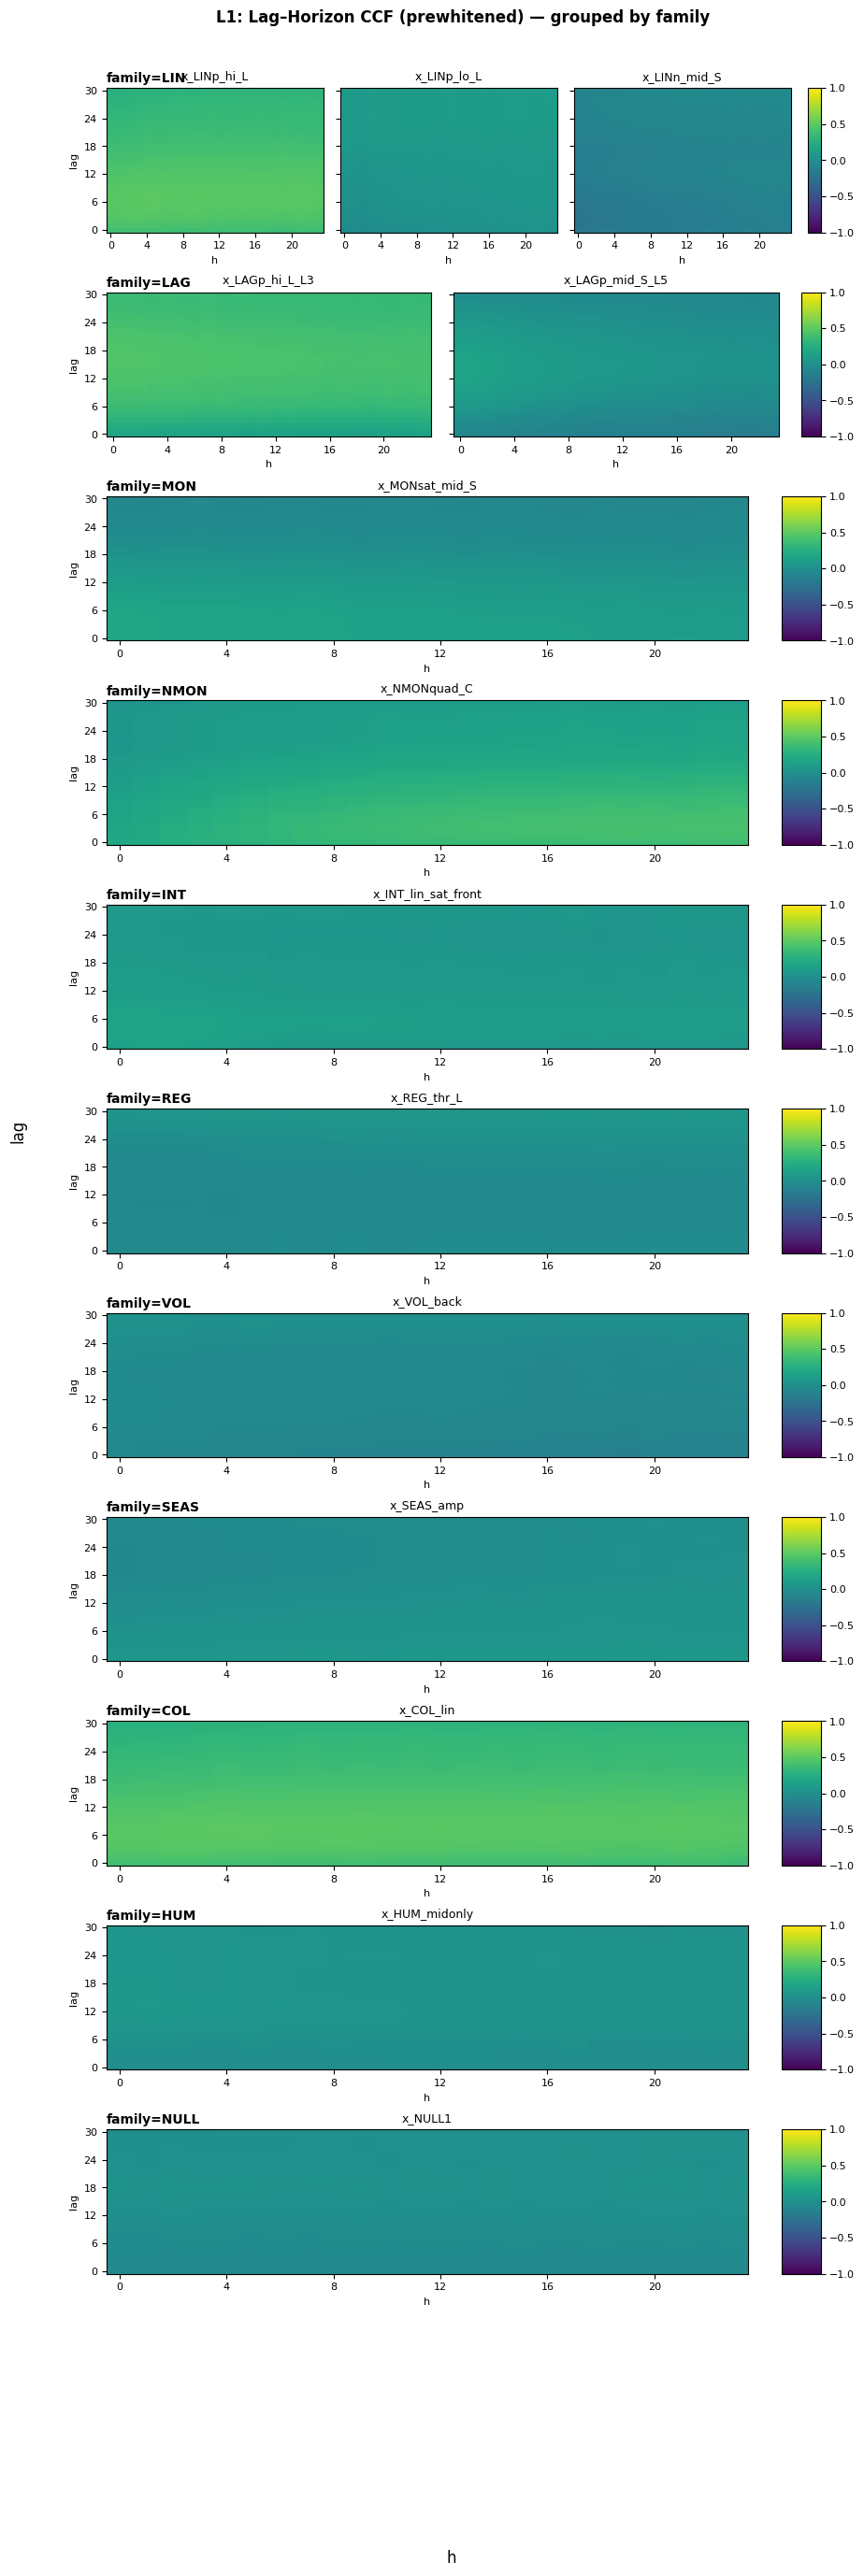

In [3]:
from src.metrics.l1_lag_horizon import *


fig, _ = plot_grid_by_taxonomy(
    X.columns,
    plot_fn=l1_plot_panel,
    grouping=("family",),                  # rows = family
    order_within=("target","sign","strength","lag"),
    max_cols=4,
    figsize_per_cell=(3.1, 2.5),
    title="L1: Lag–Horizon CCF (prewhitened) — grouped by family",
    colorbar_policy="group_right",
    plot_fn_kwargs=dict(X=X, Y=Y, max_lag=30, ar_maxlag=12, vmin=-1, vmax=1),
    families_order=["LIN","LAG","MON","NMON","INT","REG","VOL","SEAS","COL","HUM","NULL"],
)
plt.show()


## L2: Nelson–Siegel curve factors (Level/Slope/Curvature)

# L2: Nelson–Siegel factors — x_LINp_hi_L
- lambda: 0.0500
- R^2 mean: 0.558 | median: 0.615

## Sample of factor scores (head)
|                     |    level |     slope |   curvature |
|:--------------------|---------:|----------:|------------:|
| 2010-01-01 00:00:00 | 2983.3   | -2982.21  |   -3116.42  |
| 2010-01-04 00:00:00 |  621.591 |  -621.831 |    -667.359 |
| 2010-01-05 00:00:00 | 4099.92  | -4098.82  |   -4288.37  |
| 2010-01-06 00:00:00 | 2257.77  | -2254.79  |   -2409.36  |
| 2010-01-07 00:00:00 | 3068.68  | -3062.95  |   -3262.08  |
| 2010-01-08 00:00:00 |  825.43  |  -820.709 |    -948.696 |
| 2010-01-11 00:00:00 | 6133.94  | -6126.81  |   -6437.02  |
| 2010-01-12 00:00:00 | 4309.8   | -4300.75  |   -4584.64  |
| 2010-01-13 00:00:00 | 4148.77  | -4136.88  |   -4470.63  |
| 2010-01-14 00:00:00 | 4771.96  | -4758.23  |   -5067.26  |

## Correlation with factors by lag
|   lag |      level |     slope |   curvature |
|------:|-----------:|----------:|------------:|
|     

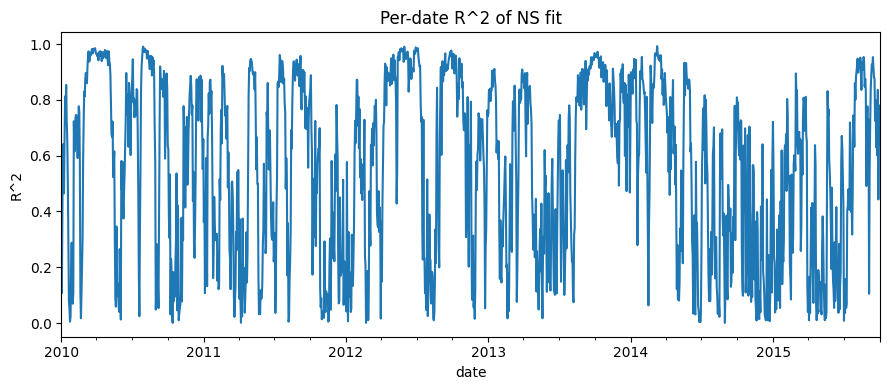

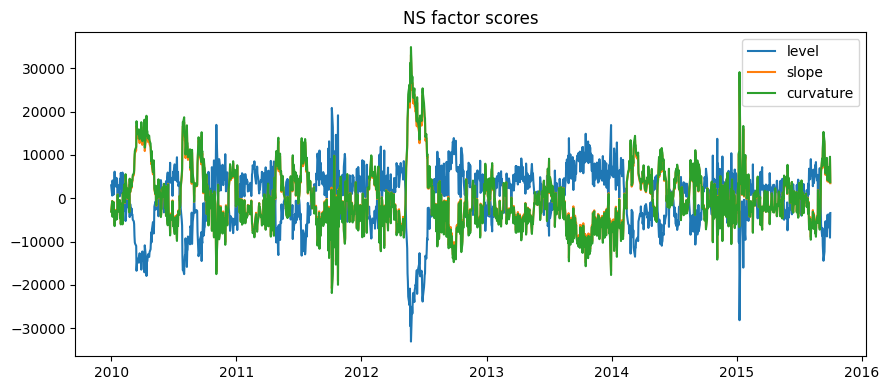

/home/tonso/code/10--learn/Agropec/src/sim.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


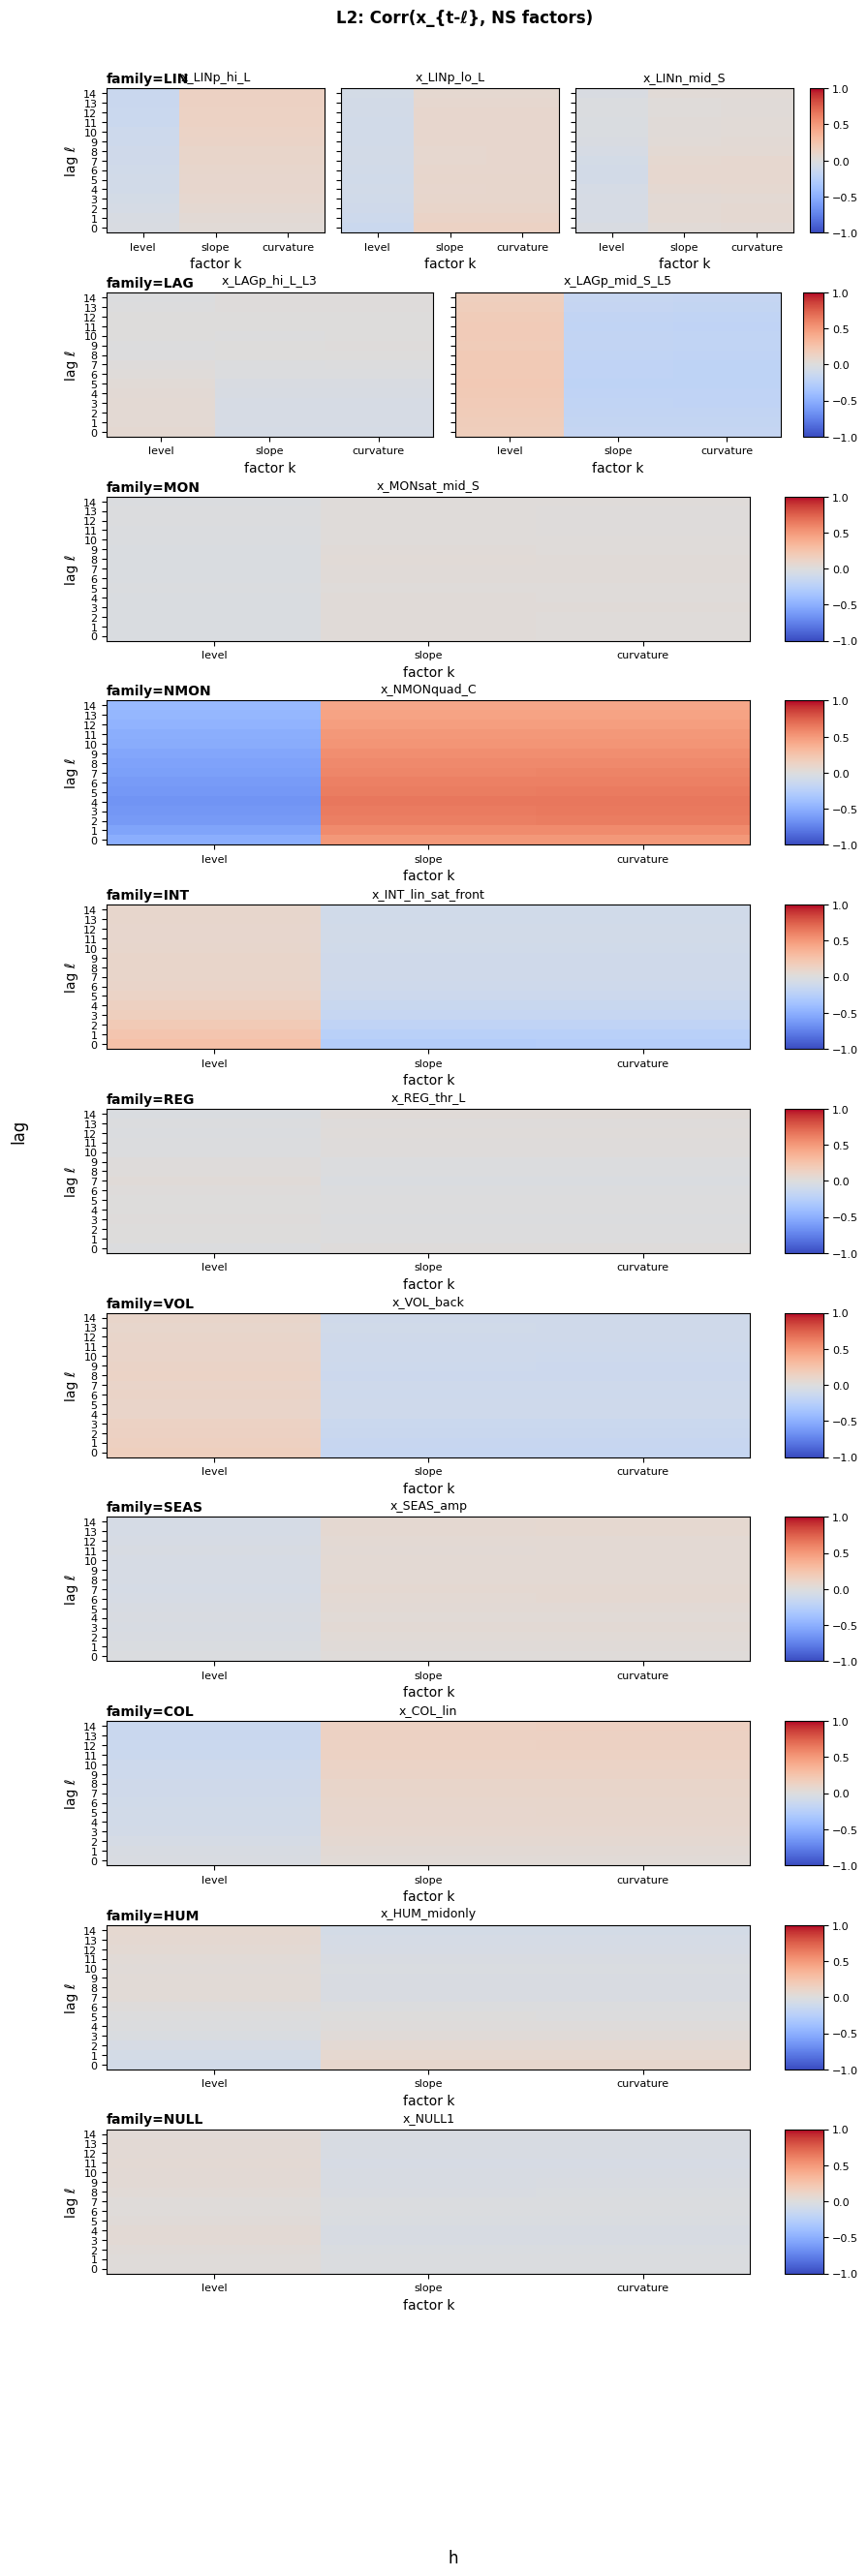

In [4]:
from src.metrics.l2_nelson_siegel import *

if __name__ == "__main__":
    res_ns = l2_ns_factors(Y=Y, x=x, lags=range(0,15), lam=None)
    l2_ns_report(res_ns)


    fig, _ = plot_grid_by_taxonomy(
        X.columns,
        plot_fn=l2_plot_corr_heatmap,
        grouping=("family",),   # rows by family
        max_cols=3,
        figsize_per_cell=(3.0, 2.4),
        title="L2: Corr(x_{t-ℓ}, NS factors)",
        colorbar_policy="group_right",
        plot_fn_kwargs=dict(X=X, Y=Y, lags=range(0,15), vmin=-1, vmax=1, cmap="coolwarm"),
        families_order=["LIN","LAG","MON","NMON","INT","REG","VOL","SEAS","COL","HUM","NULL"],
    )
    plt.show()


## L3: Partial Least Squares (PLS) — Window of X vs Full Future Curve Y

/home/tonso/code/10--learn/Agropec/src/sim.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


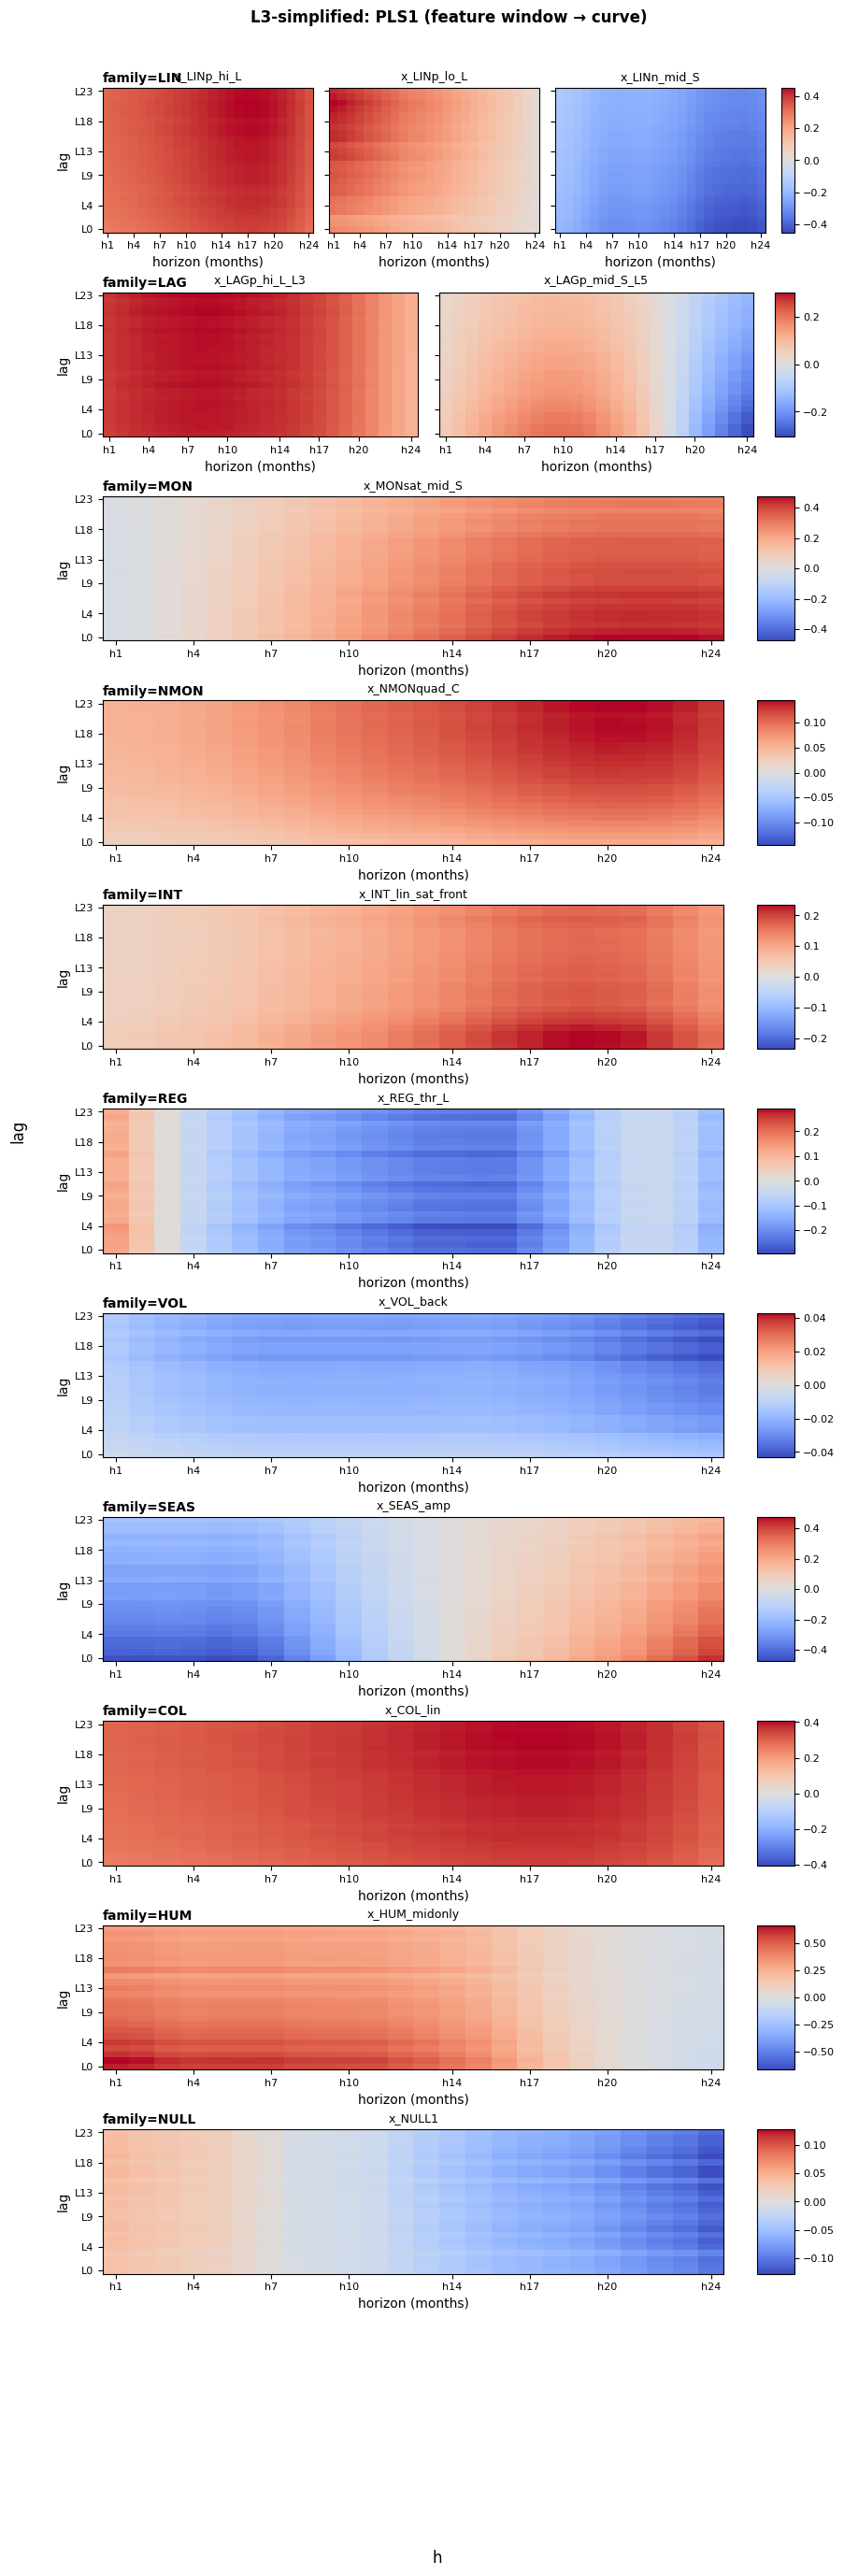

In [5]:

from src.metrics.l3_pls import *



fig, _ = plot_grid_by_taxonomy(
    X.columns,
    plot_fn=l3_pls1_panel,
    grouping=("family",),
    max_cols=3,
    figsize_per_cell=(3.0, 2.5),
    title="L3-simplified: PLS1 (feature window → curve)",
    colorbar_policy="group_right",
    plot_fn_kwargs=dict(X=X, Y=Y, window=24, n_components=1, scale=True, cmap="coolwarm"),
    families_order=["LIN","LAG","MON","NMON","INT","REG","VOL","SEAS","COL","HUM","NULL"],
)
plt.show()


# Nonlinear

## N1: Distance Correlation (dCor) — Windowed Drivers vs Future Curve

/home/tonso/code/10--learn/Agropec/src/sim.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


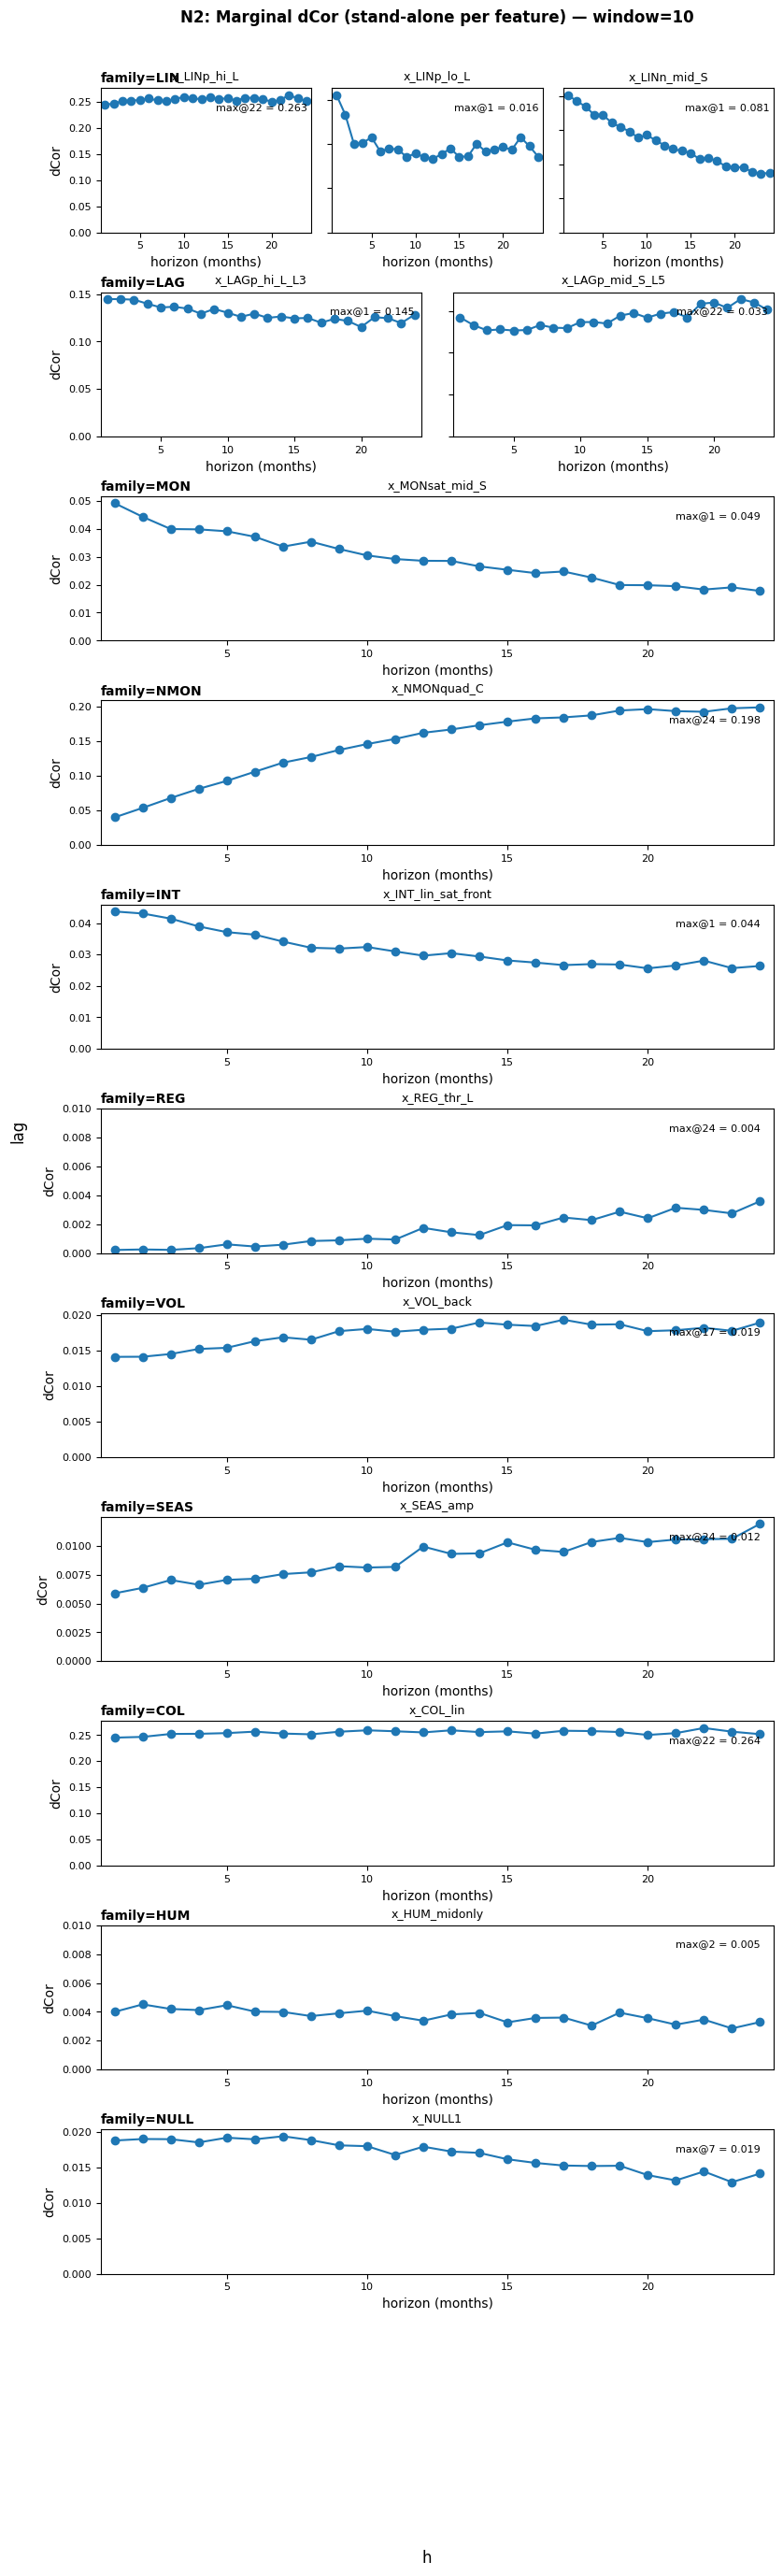

In [6]:
from src.metrics.n1_dcor import *

collection = n2_marginal_all_features(
    X, Y, window=10, max_samples=1500, random_state=0, compute_dtype="float32"
)

fig, _ = plot_grid_by_taxonomy(
    X.columns,
    plot_fn=n2_plot_panel,
    grouping=("family",),                 # rows = family (yours)
    order_within=("target","sign","strength","lag"),
    max_cols=4,
    figsize_per_cell=(3.1, 2.5),
    title=f"N2: Marginal dCor (stand-alone per feature) — window={collection.window}",
    colorbar_policy=None,
    plot_fn_kwargs=dict(
        collection=collection,
        kind="line",
        y_min=0.0,
        y_max=None,
        show_max_label=True,
        title_prefix=None
    ),
    families_order=["LIN","LAG","MON","NMON","INT","REG","VOL","SEAS","COL","HUM","NULL"],
)
plt.show()


## N2: MIC (Maximal Information Coefficient), per (lag, horizon)

In [ ]:

from src.metrics.n2_mic import *


NameError: name 'T' is not defined

# Distributional

## D1: Energy Distance (High vs Low regimes of x)

In [ ]:


from src.metrics.d1_energy_dis import *


## D2: Sliced Wasserstein Distance (High vs Low regimes of x)

In [ ]:


from src.metrics.d1_energy_dis import *